# Sentiment Analysis Learning Notebook

_What is sentiment analysis?_


Sentiment analysis (SA) is a subset of natural language processing (NLP) that employs machine learning to categorize the emotional content of text. It typically classifies text as positive, negative, or neutral, but can also discern underlying emotions and intentions like purchase likelihood. Context complicates the processes underlying sentiment analysis as phrases may convey different sentiments based on context, e.g. how can a machine understand human concepts like sarcasm or irony? Different types of sentiment analysis exist, including aspect-based, which delves into specific features' sentiment, aiding businesses in identifying product strengths and weaknesses. Emotion analysis gauges emotional intensity, while intent analysis predicts action likelihood such as how likely a frustrated customer is to use your services again (unlikely I assume!).

Some real world practical examples of SA in action include:

- Social Media: companies can perform SA on text data collected from platforms like Facebook and Twitter to assess public opinion about their products and services.
- Brand Reputation Monitoring: SA can be deployed to monitor and analyse online reviews, customer feedback, and news articles to track how a brand is perceived by consumers.
- Political Analysis: SA can analyse public opinions about politicians, their parties, their policies, and recent political events.
- Financial Predictions: analysis of finance news articles and other media could be one of many tools used to try and predict stock and currency market movements.

As always, the ability to produce a capable SA model depends on the availability and quality of relevant data, as it is an ML model that has to be trained like any other so that it can learn patterns and relationships within training data to make predictions about sentiments that might be found in new data. 



_How are SA models trained?_

There are different approaches to training sentiment analysis models:

- Supervised Learning: This is the most common approach where the model is trained on a labeled dataset containing text samples and corresponding sentiment labels. Popular algorithms used for sentiment analysis in supervised learning include Support Vector Machines (SVM), Naive Bayes, and deep learning architectures like Convolutional Neural Networks (CNNs) or Recurrent Neural Networks (RNNs).

- Unsupervised Learning: In this approach, sentiment analysis models learn without explicit labeled data. Techniques like lexicon-based sentiment analysis rely on sentiment lexicons or dictionaries that map words to sentiment scores. The sentiment of a piece of text is then determined based on the presence and polarity of words in the lexicon.

- Transfer Learning: Transfer learning involves using pre-trained models on large datasets and fine-tuning them for specific tasks like sentiment analysis. Models pre-trained on large corpora, such as BERT (Bidirectional Encoder Representations from Transformers) or GPT (Generative Pre-trained Transformer, which I believe ChatGPT is based on), have been successfully adapted for sentiment analysis tasks with relatively small amounts of labeled data.

In each approach, training a sentiment analysis model typically involves preprocessing the text data (e.g., tokenization, normalization), selecting appropriate features, defining the model architecture, training the model on the labeled dataset, and then evaluating its performance on a separate test dataset. This iterative process helps optimize the model's performance for accurately predicting sentiment in unseen text.

More info available here:
https://www.nvidia.com/en-us/glossary/sentiment-analysis/#:~:text=What%20is%20Sentiment%20Analysis%3F,emotional%20tone%20of%20text%20data.


Unfortunately you can't just throw a wall of text data at your SA model and tell it to learn. You need to do quite a bit of preprocessing and feature engineering from your raw data first before you can train the model. So we need to have a go at generic NLP, then preprocessing and feature selection, then finally building the model and seeing what it outputs.

For the sake of this learning exercise, I'll be following a project by Data Science YouTuber Nicholas Renotte, who is producing a sentiment analysis model to analyse the tone of internet comments using deep learning and NLP.

https://youtu.be/ZUqB-luawZg?si=dSfCOncs4uhIZazy

## Imports & Basic EDA

In [1]:
# Acquire dataset on Toxic Comment Classification Challenge from Kaggle.
# If needed, 'pip install tensorflow tensorflow-gpu pandas matplotlib sklearn'
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
# Let's make sure tensorflow uses my GPU so that it runs faster.
tf.config.set_soft_device_placement
tf.test.is_built_with_cuda()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

df_train = pd.read_csv('sa_train.csv')
df_test_labels = pd.read_csv('sa_test_labels.csv')
df_test_data = pd.read_csv('sa_test_data.csv')

print(f'Training Data Shape: ', df_train.shape)
print(f'Training Data Columns: ', df_train.columns)
print(f'Test Label Data Shape: ', df_test_labels.shape)
print(f'Test Label Data Columns: ', df_test_labels.columns)
print(f'Test Data Shape: ', df_test_data.shape)
print(f'Test Data Columns: ', df_test_data.columns)

Num GPUs Available:  1
Training Data Shape:  (159571, 8)
Training Data Columns:  Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
Test Label Data Shape:  (153164, 7)
Test Label Data Columns:  Index(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')
Test Data Shape:  (153164, 2)
Test Data Columns:  Index(['id', 'comment_text'], dtype='object')


In [3]:
# Inspecting the training data's integrity:
def data_integrity_check(df):
    for col in df:
        print(f'\033[1mColumn Checked: \033[0m', col)
        null_count = df[col].isnull().sum()
        print(f'Null Values: {null_count}')
        duplicate_count = df[col].duplicated().sum()
        print(f'Duplicate Values: {duplicate_count}')
        data_type = df[col].dtype
        print(f'Data Type: {data_type}')

data_integrity_check(df_train)

Column Checked:  id
Null Values: 0
Duplicate Values: 0
Data Type: object
Column Checked:  comment_text
Null Values: 0
Duplicate Values: 0
Data Type: object
Column Checked:  toxic
Null Values: 0
Duplicate Values: 159569
Data Type: int64
Column Checked:  severe_toxic
Null Values: 0
Duplicate Values: 159569
Data Type: int64
Column Checked:  obscene
Null Values: 0
Duplicate Values: 159569
Data Type: int64
Column Checked:  threat
Null Values: 0
Duplicate Values: 159569
Data Type: int64
Column Checked:  insult
Null Values: 0
Duplicate Values: 159569
Data Type: int64
Column Checked:  identity_hate
Null Values: 0
Duplicate Values: 159569
Data Type: int64


### Column Dictionary:

1. id: a unique identifier for that comment.
2. comment_text: a string containing an example comment to train the model on.


3. toxic: a binary numerical identifier to state if the comment contains malicious content.

4. severe_toxic: a binary numerical identifier to state if the comment contains highly offensive malicious content.

5. obscene: a binary numerical identifier to state if the comment contains curse words or not.

6. threat: a binary numerical identifier to state if the comment contains a threat or not.

7. insult: a binary numerical identifier to state if the comment contains a personal insult or not.

8. identity_hate: a binary numerical identifier to state if the comment contains offensive material based on the recipients characteristics, e.g. racism, sexism, etc.

In [4]:
# Training data has no nulls or duplicates so let's inspect.
df_train.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## Preprocessing

In [5]:
# We will do vectorization to turn the strings into tensors.
# Write TextVectorization?? in a Python block to see how this function works.
from tensorflow.keras.layers import TextVectorization

# Need to slice the dataframe to separate text from binary classifiers.
# Binary classifiers also need to be converted to a numpy array using .values.
# This is in order to feed it into our sequential model later on.

X = df_train['comment_text']
y = df_train[df_train.columns[2:]].values

# Build the vectorizer to carry out the vectorization.
# Set max_tokens to define how many words it can learn.
# The larger its dictionary, the larger the model will be.
# Average person's vocab is 20,000 to 35,000 words.
# English language has about 200,000 words so I'll set max_tokens accordingly.
# Output_sequence_length sets max number of words it can vectorize per input.
# You could go and find the max length of comments but I chose 100 at random.
# This will give many extra zeroes so remember to set mask_zeros=True later.
# Output mode tells the vectorizer to map each word to an integer value.

vectorizer = TextVectorization(max_tokens=200000,
                               output_sequence_length=100,
                               output_mode='int')

# Adapt the TextVectorization layer to the training data
vectorizer.adapt(X.values)

# Apply the vectorizer to your text data
X_vectorized = vectorizer(X.values)

# Print the first few examples of the vectorized text
print(X_vectorized[:3])

tf.Tensor(
[[  643    76     2   123   126   172    28   648  4615 11627  1273    83
    313    53  2068 10981    51  6607    16    62  2666   144     8  2804
     34   114  1159 15750  2869     5    46    55   235     2   419    31
      2    45    29   142    70  3394 79603     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    1    54  2506    14  1419  3653    70  4232  2564    22    94    45
  31459   941  1108  8070   178     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0


In [6]:
# Great it works! Now we need to make a tensorflow data pipeline.
# This will efficiently feed the vectorization data to the model later on.
# This helps with computation efficiency with large datasets since...
# We have 160,000 comments to analyze!

# Input target variable and data features.
dataset = tf.data.Dataset.from_tensor_slices((X_vectorized, y))

# Cache the dataset in memory, shuffle all 160,000 comments.
# Group and store comments in batches of 16.
# Prefetch half batches to prevent processing bottlenecks.
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

# Code in your test/validate/train splits to partition the pipeline.
# I decided on a train/validate/test split of 70/20/10.
# Use .take() and .skip() to partition the dataset.
train_size = int(0.7 * len(dataset))
validate_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - validate_size

# Split the dataset
train_dataset = dataset.take(train_size)
validate_dataset = dataset.skip(train_size).take(validate_size)
test_dataset = dataset.skip(train_size + validate_size).take(test_size)

## Model Building & Training

In [7]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional
# Restating max tokens as 200,000 from earlier.
max_tokens = 200000

# We want a sequential model with multiple layers.
# Add +1 after max tokens to ensure input layers match.
# Set embedding space to size 32.

# LSTM layer 32 units with tanh.
# Bidirectional wrapper since this is a Recurrent Neural Network.
# 3 Dense layers to analyze features with ReLU activation.

# Final dense layer mapped to 6 outputs to match y feature length.
# Sigmoid activation because output is binary/categorical from 0 to 1.
# mask_zero=True stops padding of zero tokens from biasing learning.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_tokens + 1, 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(6, activation='sigmoid')])

# Now we compile to model and set the optimizer.
# BinaryCrossentropy for loss because output is binary classifier.
# Can use Adam or Stochastic Gradient Descent (SGD)  as optimizer.
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          12800064  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                        

In [8]:
# Let's start the training process. I set epochs as 3.
# Use train/test/validate splits that we defined earlier.
trained_model = model.fit(train_dataset, epochs=3, validation_data=validate_dataset)

Epoch 1/3
6981/6981 [==============================] - 700s 99ms/step - loss: 0.0605 - val_loss: 0.0463
Epoch 2/3
6981/6981 [==============================] - 654s 94ms/step - loss: 0.0460 - val_loss: 0.0401
Epoch 3/3
6981/6981 [==============================] - 664s 95ms/step - loss: 0.0399 - val_loss: 0.0346


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1000x500 with 0 Axes>

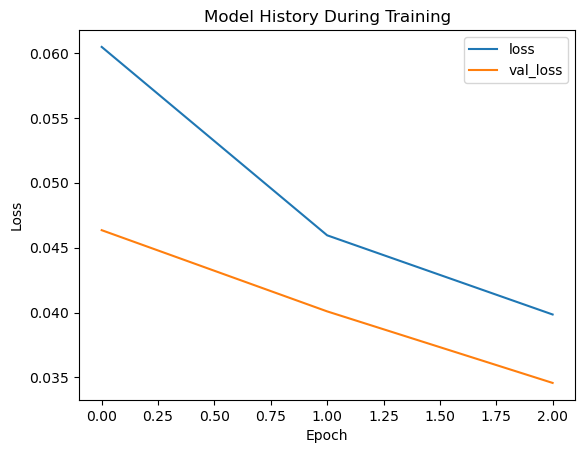

In [9]:
# Let's see training performance history for evaluation purposes.

plt.figure(figsize=(10, 5))
pd.DataFrame(trained_model.history).plot()
plt.title('Model History During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show

## Evaluation

In [10]:
# Create a dummy comment to use vectorizer on.
input_text = vectorizer('Your data work is crap because you are stupid and ugly!')

# Expand dimensions so that the tensor is neatly converted to a NumPy array.
# Then make a prediction using the trained model and print the result.
result = model.predict(np.expand_dims(input_text, 0))

# Convert results to percentage format from decimal and print:
result = [[format(num, '.2f') for num in sublist] for sublist in result]
print(result)

# Remind ourselves which column those numbers correspond to.
print(df_train.columns[2:])

1/1 [==============================] - 4s 4s/step
[['0.99', '0.14', '0.89', '0.06', '0.80', '0.13']]
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


The above output tells us that the input_text phrase "Your data work is crap because you are stupid and ugly!" is toxic, obscene, and insulting but not severely toxic, threatening, or containing identity-based hate content. Its accuracy appears to be sound. Let's try more robust evaluation metrics now.

In [11]:
# Classification model, so we evaluate performance using Precision and Recall.
# You could use Scikit-Learn but TensorFlow has them too!
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
rec = Recall()
acc = CategoricalAccuracy()

# Instantiate new data from df_test:
test_dataset = df_test_data
X = df_test_data['comment_text']
y_true = df_test_labels[df_test_labels.columns[1:]]

# I note that test_labels changes its format from 0 and 1 to 0 and -1.
# Need to modify this to ensure consistency with training data labels.
y_true = y_true.replace(-1, 1)

In [12]:
# Re-apply preprocessing steps from earlier:
vectorizer.adapt(X.values)
X_vectorized = vectorizer(X.values)
test_dataset = tf.data.Dataset.from_tensor_slices((X_vectorized, y_true))
test_dataset = test_dataset.cache()
test_dataset = test_dataset.shuffle(160000)
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.prefetch(8)

# Run model & metrics on entire test dataset now.
model.predict(test_dataset)

# Run the model and calculate metrics:
# yhat.round() to ensure prediction output is 0 or 1. 
# >= 0.5 = 1, < 0.5 = 0.

for X_true, y_true in test_dataset:
    yhat = model.predict(X_true)
    # Flatten and round the predictions
    y_true = np.array(y_true).flatten()
    yhat = np.array(yhat).flatten()
    yhat = yhat.round()
    # Update Metrics per batch
    pre.update_state(y_true, yhat)
    rec.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 24ms/step


In [13]:
# Let's print the outputs now, convert to numpy array first.
precision_score = pre.result().numpy()
recall_score = rec.result().numpy()
accuracy_score = acc.result().numpy()

# Formatting the scores to two decimal places for easier reading.
precision_formatted = "{:.2f}".format(precision_score)
recall_formatted = "{:.2f}".format(recall_score)
accuracy_formatted = "{:.2f}".format(accuracy_score)

print(f'Overall Precision: {precision_formatted}, Overall Recall: {recall_formatted}, Overall Accuracy: {accuracy_formatted}')

Overall Precision: 0.62, Overall Recall: 0.03, Overall Accuracy: 0.19


In [14]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Collect true labels and predicted probabilities:
y_true = []
yhat = []

for X_true, y_batch in test_dataset:
    y_true.append(y_batch.numpy())
    yhat.append(model.predict(X_true))

# Concatenate lists to create single NumPy arrays:
y_true = np.concatenate(y_true)
yhat = np.concatenate(yhat)

1/1 [==============================] - 0s 18ms/step


In [15]:
# Compute AUC for each label:
auc_scores = []
for i in range(6):  
    auc_scores.append(roc_auc_score(y_true[:, i], yhat[:, i]))

# Average AUC scores over all labels:
avg_auc = np.mean(auc_scores)
print("Average AUC:", avg_auc)

Average AUC: 0.4993802232275871


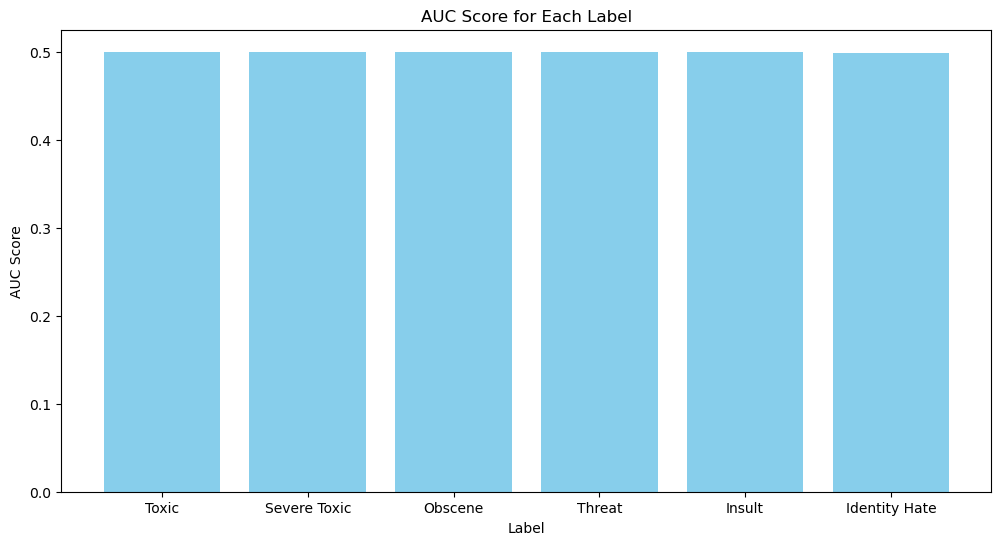

In [16]:
# Plot AUC on a graph:
plt.figure(figsize=(12, 6))
plt.bar(range(6), auc_scores, color='skyblue')
plt.xlabel('Label')
plt.ylabel('AUC Score')
plt.title('AUC Score for Each Label')
plt.xticks(range(6), ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate'])
plt.show()

## Optimization Notes:

First result: Overall Precision: 0.61, Overall Recall: 0.05, Overall Accuracy: 0.07 

This is awful and I suspect the model has been overfitted to the training data. I am going to reset everything and reduce the number of training epochs to see if this does the trick. I also noticed different conventions in the test_label file so I accounted for that.

Second result: Overall Precision: 0.61, Overall Recall: 0.03, Overall Accuracy: 0.19

Reducing the training epochs to 5 and swapping the -1 for 1 in test_labels appear to have improved accuracy, but recall stayed low. Both are too low for my liking, let's try reducing training epochs to three. 

Third result: Overall Precision: 0.61, Overall Recall: 0.03, Overall Accuracy: 0.19

No change, so let's leave training there. 

Fourth result: Overall Precision: 0.61, Overall Recall: 0.02, Overall Accuracy: 0.21

I modified the NN architecture and double checked y_true and yhat were correctly assigned. 

Fifth result: Overall Precision: 0.61, Overall Recall: 0.03, Overall Accuracy: 0.19, AUC: 0.501

I removed batching to see if this affected anything. I also increased training epochs to 4 and added AUC-ROC.

Let's try some more models to see if they can perform better than the neural network. I will also modify my preprocessing steps to see if that helps. The model in this workbook has been retired.